# SegNet CamVid Workflow

This notebook:
- Uses the modular Python files (`model_segnet.py`, `data_camvid.py`, `metrics_camvid.py`, `train_segnet_camvid.py`, `eval_segnet_camvid.py`, `visualize_segnet_camvid.py`).
- Does some quick exploratory data analysis (EDA) on the CamVid dataset.
- Lets you train, evaluate, and visualise SegNet from within the notebook.

Make sure all these `.py` files and your `SegNet/CamVid/*.txt` file lists are in the same project directory as this notebook.

In [1]:
import os

repo_url = 'https://github.com/Samuelameningayeh/segNet2.git'
repo_name = repo_url.split('/')[-1].replace('.git', '')

# Clone the repository
print(f"Cloning {repo_url}...")
!git clone {repo_url}

# Change the current working directory to the cloned repository's root
if os.path.exists(repo_name):
    os.chdir(repo_name)
    print(f"Successfully changed current working directory to: {os.getcwd()}")
else:
    print(f"Error: Cloned repository directory '{repo_name}' not found.")


Cloning https://github.com/Samuelameningayeh/segNet2.git...
Cloning into 'segNet2'...
remote: Enumerating objects: 1427, done.
remote: Counting objects: 100% (1427/1427), done.
remote: Compressing objects: 100% (1423/1423), done.
remote: Total 1427 (delta 3), reused 1427 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (1427/1427), 178.44 MiB | 29.69 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Successfully changed current working directory to: /content/segNet2


In [2]:
print('Verifying Git setup:')
!git remote -v
!git branch


Verifying Git setup:
origin	https://github.com/Samuelameningayeh/segNet2.git (fetch)
origin	https://github.com/Samuelameningayeh/segNet2.git (push)
* main


In [3]:

import os
import random

import numpy as np
import matplotlib.pyplot as plt
import torch

from model_segnet import SegNet
from data import CamVidDataset, get_camvid_loaders, get_camvid_test_loader
from metrics import compute_confusion_matrix, metrics_from_confusion_matrix

# Paths to your file lists (edit if needed)
train_txt = "CamVid/train.txt"
val_txt = "CamVid/val.txt"
test_txt = "CamVid/test.txt"

img_size = (360, 480)
num_classes = 12  # your masks use labels 0..11
batch_size = 4
num_workers = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)


Using device: cuda


## 1. Load dataset objects and inspect basic info

In [4]:

# Instantiate datasets directly (no DataLoader yet) for simple inspection
train_ds = CamVidDataset(train_txt, img_size=img_size)
val_ds = CamVidDataset(val_txt, img_size=img_size)

print('Train samples:', len(train_ds))
print('Val samples  :', len(val_ds))

# Show first few image/mask paths from the txt file
with open(train_txt, 'r') as f:
    for i, line in enumerate(f):
        if i >= 5:
            break
        print(line.strip())


Train samples: 367
Val samples  : 101
/SegNet/CamVid/train/0001TP_006690.png /SegNet/CamVid/trainannot/0001TP_006690.png
/SegNet/CamVid/train/0001TP_006720.png /SegNet/CamVid/trainannot/0001TP_006720.png
/SegNet/CamVid/train/0001TP_006750.png /SegNet/CamVid/trainannot/0001TP_006750.png
/SegNet/CamVid/train/0001TP_006780.png /SegNet/CamVid/trainannot/0001TP_006780.png
/SegNet/CamVid/train/0001TP_006810.png /SegNet/CamVid/trainannot/0001TP_006810.png


## 2. Visualise a few random training samples

Sample index: 219 Img shape: torch.Size([3, 360, 480]) Mask shape: torch.Size([360, 480])


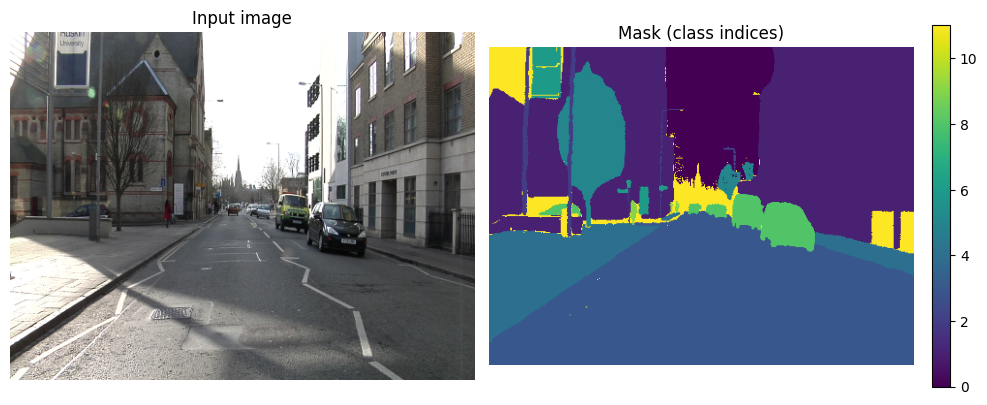

In [5]:

def show_sample(idx=None):
    if idx is None:
        idx = random.randint(0, len(train_ds) - 1)
    img, mask = train_ds[idx]
    print('Sample index:', idx, 'Img shape:', img.shape, 'Mask shape:', mask.shape)

    # Denormalise image for display
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img_vis = img * std + mean
    img_vis = torch.clamp(img_vis, 0, 1)
    img_vis = img_vis.permute(1, 2, 0).numpy()

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(img_vis)
    axes[0].set_title('Input image')
    axes[0].axis('off')

    im = axes[1].imshow(mask.numpy())
    axes[1].set_title('Mask (class indices)')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

show_sample()  # run again with different idx if you like


## 3. Quick class distribution check (on a subset of train set)

Raw pixel counts per class (subset of 50 images):
Class 0: 1651157 pixels
Class 1: 2238838 pixels
Class 2: 82345 pixels
Class 3: 1601013 pixels
Class 4: 423889 pixels
Class 5: 1102889 pixels
Class 6: 107800 pixels
Class 7: 44646 pixels
Class 8: 729730 pixels
Class 9: 54483 pixels
Class 10: 29690 pixels
Class 11: 573520 pixels


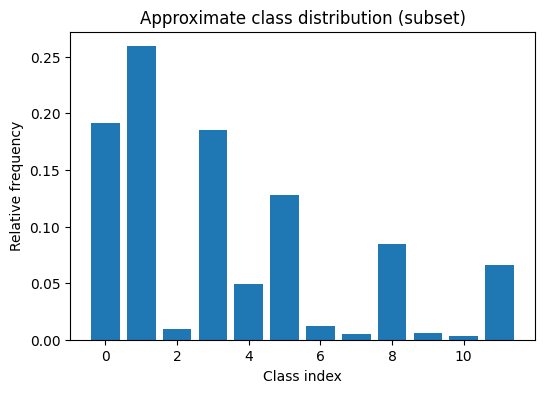

In [6]:

subset_size = min(50, len(train_ds))  # adjust if you want more
class_counts = np.zeros(num_classes, dtype=np.int64)

for i in range(subset_size):
    _, mask = train_ds[i]
    vals, counts = np.unique(mask.numpy(), return_counts=True)
    for v, c in zip(vals, counts):
        if 0 <= v < num_classes:
            class_counts[v] += c

print('Raw pixel counts per class (subset of {} images):'.format(subset_size))
for c, cnt in enumerate(class_counts):
    print(f'Class {c}: {cnt} pixels')

# Normalised frequencies
freqs = class_counts / class_counts.sum()

plt.figure(figsize=(6, 4))
plt.bar(np.arange(num_classes), freqs)
plt.xlabel('Class index')
plt.ylabel('Relative frequency')
plt.title('Approximate class distribution (subset)')
plt.show()


## 4. Create DataLoaders and inspect a batch

In [7]:

train_loader, val_loader = get_camvid_loaders(
    train_txt, val_txt,
    img_size=img_size,
    batch_size=batch_size,
    num_workers=num_workers,
)

batch = next(iter(train_loader))
imgs_batch, masks_batch = batch
print('Batch image tensor shape:', imgs_batch.shape)  # (B, 3, H, W)
print('Batch mask tensor shape :', masks_batch.shape) # (B, H, W)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Batch image tensor shape: torch.Size([4, 3, 360, 480])
Batch mask tensor shape : torch.Size([4, 360, 480])


## 5. Run training from notebook
You can either:
- Use `%run train_segnet_camvid.py` to execute the script as-is, or
- Import its `main()` and call it.

Below we show the `%run` approach (edit hyperparameters inside `train_segnet_camvid.py`).

In [9]:
%run train_segnet.py

Using device: cuda


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Computing class weights...
Class weights: [ 0.23439573  0.16976146  4.0170035   0.12472033  0.8801125   0.40604696
  3.3662226   3.5040758   0.6731392   6.1768317  13.537523    1.        ]


TypeError: cross_entropy_loss(): argument 'ignore_index' (position 5) must be int, not NoneType

## 6. Evaluate best model on test set

In [ ]:

from eval import evaluate_model

checkpoint = 'segnet_camvid_best.pth'
evaluate_model(checkpoint, test_txt,
               img_size=img_size,
               num_classes=num_classes,
               batch_size=batch_size,
               num_workers=num_workers)


## 7. Visualise predictions (input | ground truth | prediction)

In [ ]:

from visualise import visualize_predictions

checkpoint = 'segnet_camvid_best.pth'
list_txt = val_txt  # or test_txt

visualize_predictions(
    checkpoint_path=checkpoint,
    list_txt=list_txt,
    out_dir='vis_from_notebook',
    num_classes=num_classes,
    img_size=img_size,
    max_batches=2,
    batch_size=batch_size,
    num_workers=num_workers,
)
